### Task-1
### Import libraries

In [1]:
import tensorflow as tf
import keras

import numpy as np
import os
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import LambdaCallback
#from keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download Shakespeare Dataset
path_to_file = keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')


Length of text: 1115394 characters


In [4]:
print(text[:250])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')


65 unique characters


### Text processing

In [ ]:
# Vectorize the text
#ids_from_chars = keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
#chars_from_ids = keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [9]:
# creates mapping of unique characters to integers
chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))# Prints the total characters and character vocab size
n_chars = len(text)
n_vocab = len(chars)

print("The number of total characters are", n_chars)
print("\nThe character vocab size is", n_vocab)

The number of total characters are 1115394

The character vocab size is 65


In [10]:
#Prepares dataset where the input is sequence of 100 characters and target is next character.
seq_length = 100

dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
  seq_in = text[i:i + seq_length]
  seq_out = text[i + seq_length]

  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)# reshapes X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))

# one hot encodes the output variable
y = np_utils.to_categorical(dataY)

Total Patterns:  1115294


In [8]:
X.shape

(1115294, 100, 1)

### Define model

In [13]:
embedding_dim =256
max_length =100

model1 = Sequential()
model1.add(Embedding(n_vocab, embedding_dim, input_length=max_length))
model1.add(LSTM(256, input_shape=(X.shape[1], embedding_dim),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(256))
model1.add(Dropout(0.2))
model1.add(Dense(y.shape[1], activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 256)          16640     
                                                                 
 lstm_2 (LSTM)               (None, 100, 256)          525312    
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 65)                16705     
                                                                 
Total params: 1,083,969
Trainable params: 1,083,969
No

In [16]:
# Define a callback to compute perplexity
def on_epoch_end(epoch, logs):
    if epoch % 10 == 0:
        perplexity = np.exp(logs['val_loss'])
        print(f'Epoch {epoch}: perplexity = {perplexity}')

# Use a tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training:
        
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)



In [18]:
history = model1.fit(X, y, batch_size=2048, epochs=31,validation_split=0.2, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end),checkpoint_callback])

Epoch 1/31
436/436 [==============================] - 124s 285ms/step - loss: 1.9870 - val_loss: 1.8843
Epoch 2/31
436/436 [==============================] - 124s 283ms/step - loss: 1.7460 - val_loss: 1.7606
Epoch 3/31
436/436 [==============================] - 124s 283ms/step - loss: 1.6180 - val_loss: 1.6875
Epoch 4/31
436/436 [==============================] - 124s 284ms/step - loss: 1.5406 - val_loss: 1.6555
Epoch 5/31
436/436 [==============================] - 124s 284ms/step - loss: 1.4863 - val_loss: 1.6227
Epoch 6/31
436/436 [==============================] - 124s 284ms/step - loss: 1.4463 - val_loss: 1.5990
Epoch 7/31
436/436 [==============================] - 124s 284ms/step - loss: 1.4154 - val_loss: 1.5846
Epoch 8/31
436/436 [==============================] - 123s 283ms/step - loss: 1.3917 - val_loss: 1.5756
Epoch 9/31
436/436 [==============================] - 124s 284ms/step - loss: 1.3692 - val_loss: 1.5708
Epoch 10/31
436/436 [==============================] - 124s 284m

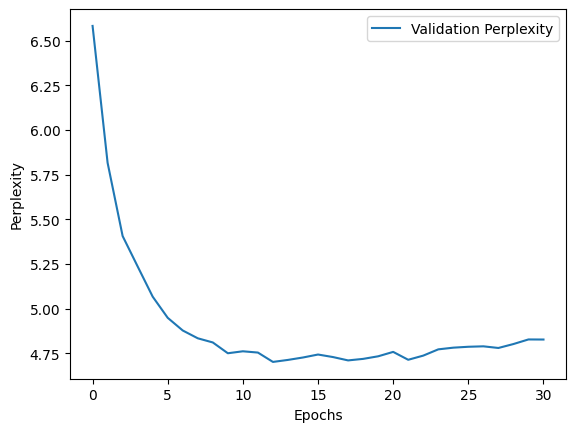

In [24]:
#Plot the change in perplexity during training
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
perplexity = np.exp(val_loss)
epochs = 31
epochs_range = range(epochs)

plt.plot(epochs_range, perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

In [55]:
export_path = 'model/char-rnn'
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model1,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    
    )

export_path = model/char-rnn



In [56]:
! zip -r model.zip /kaggle/working/model/char-rnn

  adding: kaggle/working/model/char-rnn/ (stored 0%)
  adding: kaggle/working/model/char-rnn/saved_model.pb (deflated 90%)
  adding: kaggle/working/model/char-rnn/variables/ (stored 0%)
  adding: kaggle/working/model/char-rnn/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/model/char-rnn/variables/variables.index (deflated 62%)
  adding: kaggle/working/model/char-rnn/fingerprint.pb (stored 0%)
  adding: kaggle/working/model/char-rnn/keras_metadata.pb (deflated 90%)
  adding: kaggle/working/model/char-rnn/assets/ (stored 0%)


In [57]:
#Save model
import os
from IPython.display import FileLink
os.chdir(r'/kaggle/working')
FileLink(r'model.zip')

/kaggle/working/model.zip

### Task-2

In [58]:
model = tf.keras.models.load_model(export_path)

In [59]:
# Define a function to generate text given a seed sequence
def generate_text(model, seed_sequence, length=100):
    generated_text = seed_sequence
    for i in range(length):
        x_pred = np.zeros((1, seq_length, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_to_int[char]] = 1

        preds = model.predict(x_pred)
        next_index = np.random.choice(len(chars), p=preds)
        next_char = int_to_char[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

    return generated_text



In [60]:
# Generate 3 sequences of length 100 by priming with random character sequences of length 5
for i in range(3):
    seed_sequence = ''.join(np.random.choice(chars, size=5))
    generated_sequence = generate_text(model, seed_sequence, length=100)
    print(f"Priming sequence: {seed_sequence}")
    print(f"Generated sequence: {generated_sequence}\n")

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 100, 65, 256)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 100, 65), dtype=float32)
      • training=False
      • mask=None


In [61]:
#Gets the generated string using the model.
def predict_next_n_chars(pattern, n):
    for i in range(n):
      x = np.reshape(pattern, (1, len(pattern), 1))
      prediction = model.predict(x, verbose=0)
      print (int_to_char[np.argmax(prediction)], end = '')   #get next char index.
      seq_in = [int_to_char[value] for value in pattern]
      pattern.append(np.argmax(prediction))
      pattern = pattern[1:len(pattern)]

In [62]:
#picks a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
input_str = ''.join([int_to_char[value] for value in pattern])
print ("Seed -",  input_str, sep = '\n\n')
print ("\nGenerated string -\n")

predict_next_n_chars(pattern, 100)
input_str = "First Citizen: Before we proceed any further, hear me speak."#Uses the first 100 characters from given input_str as input to generate next 100 characters. 
input_str = input_str.lower()
input_string = ''
for each in input_str:
  if each in chars:
    if (len (input_string)<100):
      input_string += each

pattern = []
pattern.append([char_to_int[char] for char in input_string])

print ("Seed -\n",  input_str, sep = '\n\n')
print ("\nGenerated string -\n")
predict_next_n_chars(pattern[0], 100)

Seed -

ion.

ANGELO:
You seem'd of late to make the law a tyrant;
And rather proved the sliding of your bro

Generated string -

ther,
And the sun and strength and the state is so.

KING RICHARD III:
Why, then I have said 'tis noSeed -


first citizen: before we proceed any further, hear me speak.

Generated string -



CORIOLANUS:
What is the court?

CAPULET:
What says he shall be so?

MENENIUS:
What is the court?



In [65]:
def generate_text(model, seed_sequence, length):
    # Convert the seed sequence to a one-hot encoded input
    x_pred = np.zeros((1, seq_length, len(chars)))
    for t, char in enumerate(seed_sequence):
        x_pred[0, t, char_to_int[char]] = 1

    generated_text = seed_sequence
    for i in range(length):
        preds = model.predict(x_pred, verbose=0)
        
        # Sample the next character index from the predicted probabilities
        def sample(preds, temperature=1.0):
            preds = np.asarray(preds).astype('float64')
            preds = np.log(preds) / temperature
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            return np.argmax(probas)
        
        next_index = sample(preds)
        next_char = int_to_char[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        # Update the input sequence for the next timestep
        x_pred = np.zeros((1, seq_length, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_to_int[char]] = 1

    return generated_text

In [67]:
# Define the priming sequences
priming_sequences = ['the', 'wat is', 'shall i give']

# Generate and print the sequences
for seq in priming_sequences:
    generated_sequence = generate_text(model, seq, length=100)
    print(f"Priming sequence: {seq}")
    print(f"Generated sequence: {generated_sequence}\n")

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 100, 65, 256)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 100, 65), dtype=float32)
      • training=False
      • mask=None
